**main script**
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/medicinely/fwi/blob/main/testcode.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>

In [1]:
# !git clone https://github.com/medicinely/fwi.git
# %cd fwi

# Deterministic Full Waveform Inversion

In [2]:
import time
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
labelsize = 16

from scipy.optimize import minimize
from func.propagation import prop2d, defmodel
from func.inversion import J,second_order_derivative
from func.velocity_model import check_model, gaussian2d

import tensorflow as tf
import tensorflow_probability as tfp
print('GPU:',tf.config.list_physical_devices('GPU'))
from func.propagation_tf import simulate_obs

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import cupy as cp
device = 'gpu'

## Tensorflow mapping function
# def f_tf(u, vmin=2000, vmax=3000):
#     cdf = tfp.distributions.Normal(loc=0, scale=1).cdf(u)
#     # cdf =  tf.math.exp(-tf.math.square(u_tf)) / tf.math.sqrt(2.0 * np.pi)
#     v = (vmax - vmin) * cdf + vmin
#     return v

# # Mapping function from u to v
# def f(u, vmin=2000, vmax=3000):
#     # CDF of gaussian
#     cdf = sc.stats.norm.cdf(u.flatten(), loc=0, scale=1)
#     v = (vmax-vmin) * cdf + vmin
#     return v

def f(u, a=2000, b=3000):
	'''
	Reparametrization mapping function from u -> v
	Unconstrained parameter -> Physical parameter space
	'''
	v = a+(b-a)/(1+np.exp(-u))

	return v


def f_inv(v, a=2000, b=3000):
	'''Inverse of the mapping function f^-1'''
	u = np.log(v - a) - np.log(b - v)

	return u


# Define cost function
def loglik_fn(u,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
	# J: Prior part
	v = f(u)
	log_likelihood = -J(v,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device) / alpha
 
	return log_likelihood

# Calculate gradient with Adjoint state method
def dloglik_du_fn(u,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
	"""
	Calculate gradiant using adjoint state method
	"""
	# Calculate forward propagated p_fwd(z,x,t) (to update)
	v = f(u)
	nz, nx, nt = len(az), len(ax), len(at)
	if v.ndim == 1: v = np.reshape(v,(nz,nx))
	p_fwd = prop2d(wsrc,zxsrc,v,at,az,ax,next, device)
	d = p_fwd[zxrec[0], zxrec[1], :]
	residual = d - d_obs # residual shape (n_rec, nt) - residual.shape=(5,801)
	# Calculate back propagated p_back(z,x,t)
	p_back = prop2d(np.flip(residual,axis=1), zxrec, v, at, az, ax, next, device)
	p_back = np.flip(p_back,axis=2)
	# Calculate second order time derivative of p_fwd(z,x,t)
	p_dt_dt = second_order_derivative(p_fwd, at, az, ax)
	# Calculate gradiant
	dJ_dv = 2/v**3  * np.sum(p_back * p_dt_dt, axis=2) # G.shape = (201,201)
	dloglik_dv = -dJ_dv / alpha
	dv_du = sc.misc.derivative(f,u)

	return (dloglik_dv.flatten() * dv_du.flatten())

2023-03-14 23:51:03.138568: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 23:51:03.355908: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-14 23:51:04.013268: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/yxie-l/anaconda3/envs/geostat/lib/
2023-03-14 23:51:04.013434: W tensorflow/comp

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-03-14 23:51:05.252058: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-14 23:51:05.253410: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-14 23:51:05.254023: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Forward modeling

In [3]:
## Model size (nz,nx) = (29,29)
# import pickle
# # load data
# filename = './data/u_29'
# infile = open(filename, 'rb')
# u_ref = pickle.load(infile)
# infile.close()

# filename = './data/Q_29'
# infile = open(filename, 'rb')
# Q = pickle.load(infile)
# infile.close()

# # Initialize the model axis az, ax, at
# nz,nx,nt = 29,29,235
# vmin,vmax=2000,3000
# izsrc, ixsrc = [1], [nx//2]
# next = 10

# # v_ref = gaussian2d(ranges=[20,5],variance=50,nx=[nz,nx],param=1,mean=2500)
# # u_ref, Q = gaussian2d(ranges = [20,5],param=1,nx=[nz,nx],variance=1,mean=0)
# u_ref = u_ref.flatten()
# v_ref = f(u_ref)

# az, ax, at, next, wsrc, zxsrc = defmodel(
#                       vmin=vmin, vmax=vmax, fmax=25, # key parameters
#                       nz=nz, nx=nx, nt=nt, # number of indices
#                       izsrc=izsrc, ixsrc=ixsrc,  # define source coordinates z, x
#                       ext=next)  

# # check_model(v=v_ref, vmin=vmin, vmax=vmax)
# # Set receiver z and x coordinates
# interv = 1 # interval between receivers
# receivers_width = np.append(np.arange(zxsrc[1][0],0,-interv)[::-1][:-1], #left
# 							np.arange(zxsrc[1][0],nx-1,interv)) #right
# nrec = len(receivers_width)
# # zxrec = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
# zxrec1 = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
# zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1), receivers_width)) # Bottom
# zxrec3 = np.vstack((receivers_width, np.full(nrec, zxsrc[0]))) # Left
# zxrec4 = np.vstack((receivers_width, np.full(nrec, nz-zxsrc[0]-1))) # Right
# zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))
# zxrec = zxrec1
# zxrec = np.unique(zxrec,axis=1)
# print("Number of receivers:", len(zxrec.flatten())//2)
# # d_obs = simulate_obs(f(u_ref).resh, wsrc, zxsrc, at, az, ax, next, zxrec)
# p = prop2d(wsrc,zxsrc,v_ref.reshape(nz,nx),at,az,ax,next,device)
# d_obs = p[zxrec[0], zxrec[1], :]

# plt.figure(figsize=(8,3))
# plt.subplot(1,2,1) 
# plt.imshow(v_ref.reshape((nz,nx)),vmin=2000,vmax=3000)
# plt.colorbar()
# plt.scatter(zxsrc[1,:],zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
# plt.scatter(zxrec[1,:],zxrec[0,:],marker='s',color='w',s=5,alpha=0.8,label="Receivers")
# plt.legend(loc='lower right')
# plt.title("$V_{true}$")
# plt.subplot(1,2,2)
# plt.imshow(d_obs.T,cmap='bwr',vmin=-10,vmax=10,extent=[at[0], at[-1], az[-1], az[0]], aspect='auto')
# plt.title("Observation $d_{obs}$")
# plt.show()

Min velocity: 2076.09  Max velocity 2951.19
dz,dx,dt (m): 8.0 8.0 0.001697056274847714
Model dimension [nz,nx,nt]:  200 200 800
Number of receivers: 156
shape of p(z,x,t) = (200, 200, 800)


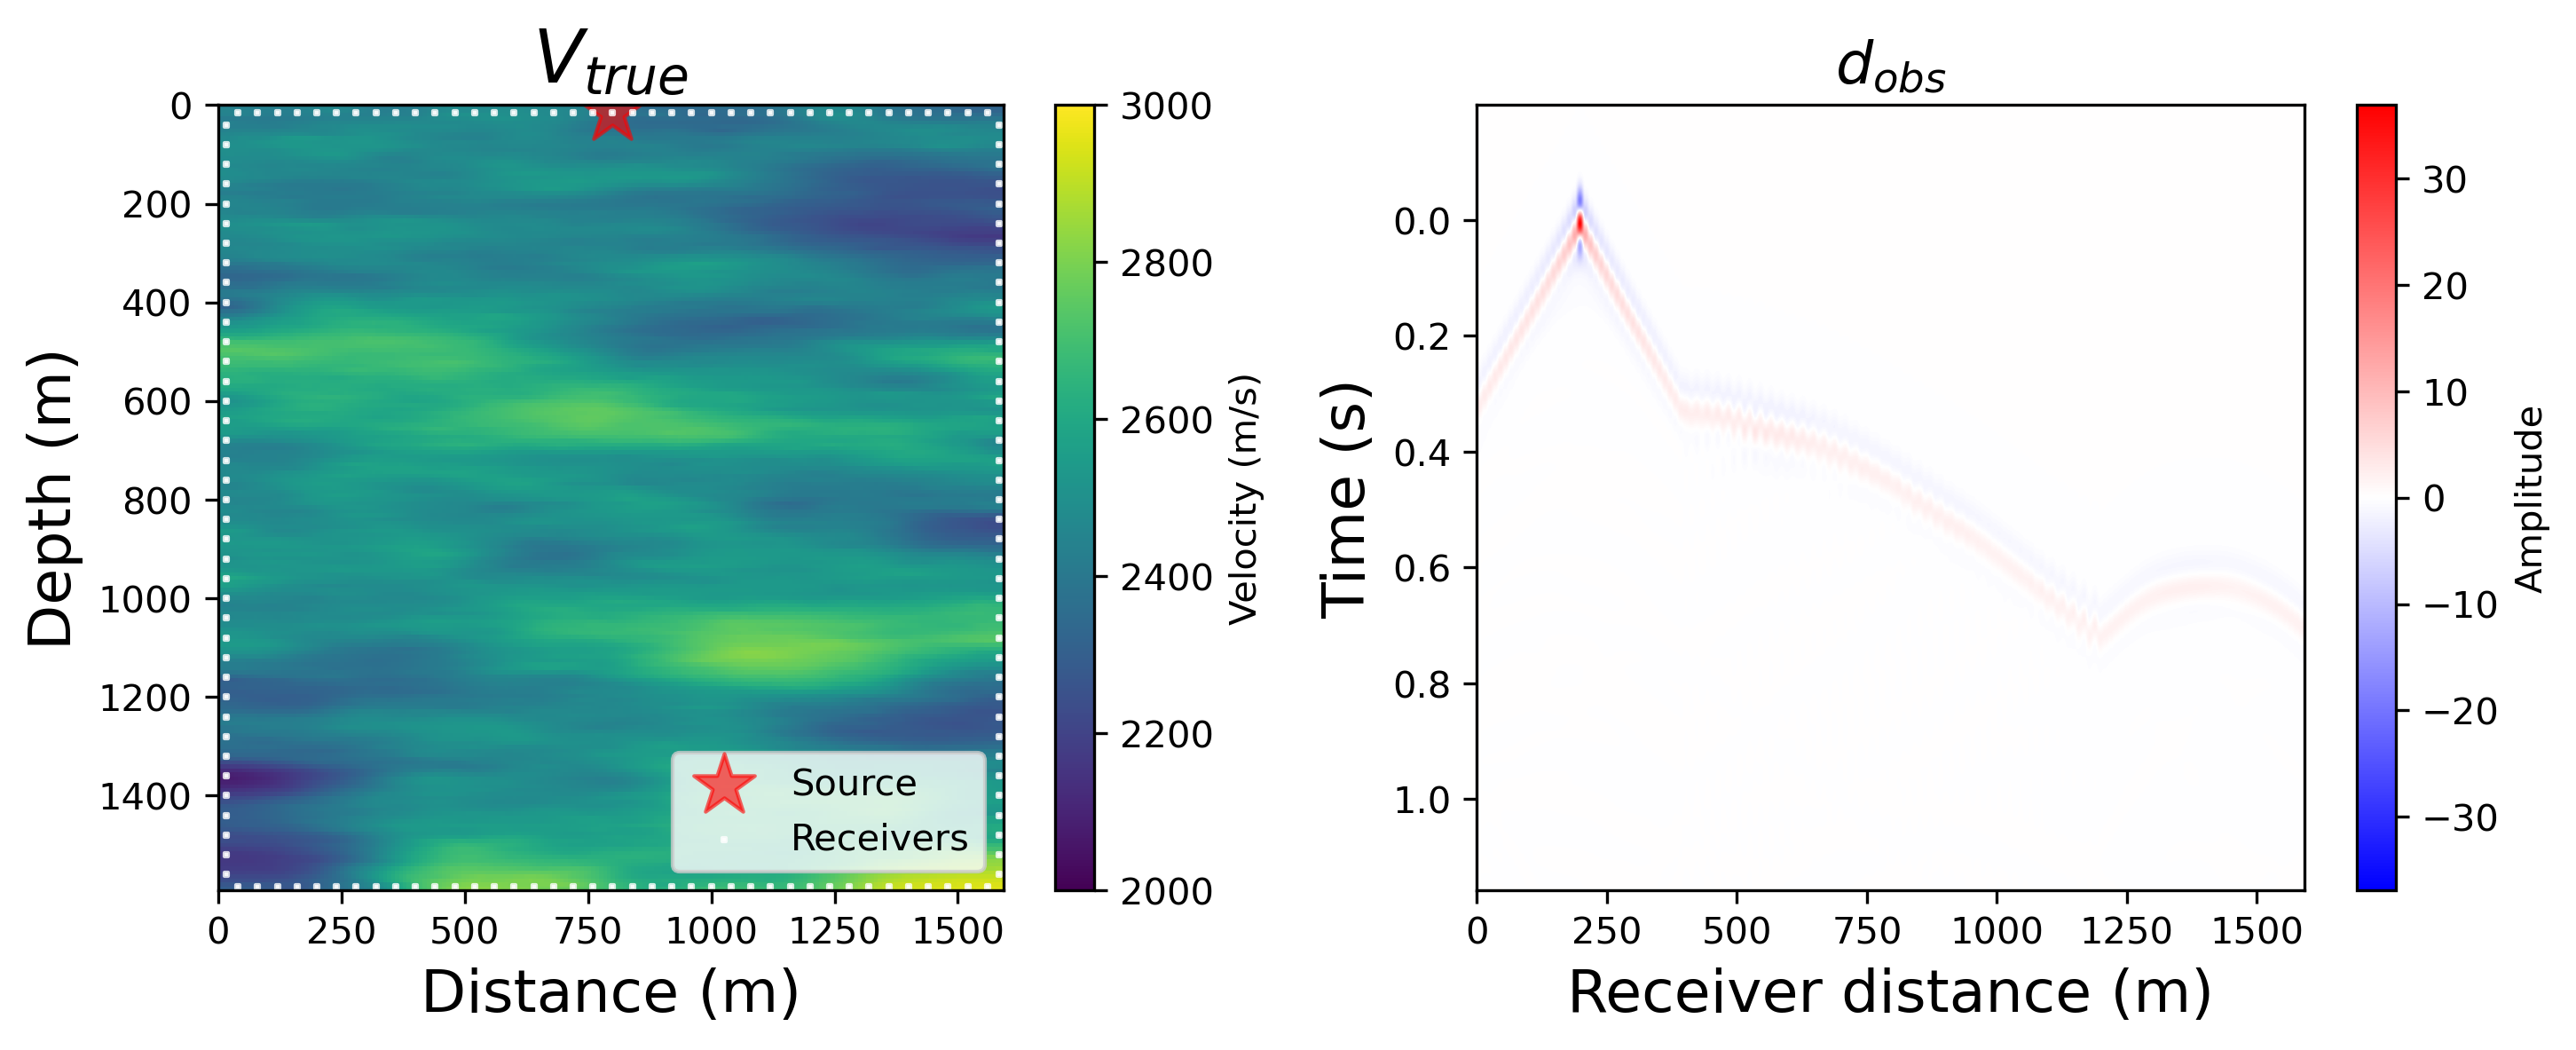

In [4]:
# Model size (nz,nx) = (200,200)

import pickle
# load data
filename = './data/u_200'
infile = open(filename, 'rb')
u_ref = pickle.load(infile)
infile.close()

filename = './data/Q_200'
infile = open(filename, 'rb')
Q = pickle.load(infile)
infile.close()

# Initialize the model axis az, ax, at
nz,nx,nt = 200,200,800
vmin,vmax = 2000,3000
izsrc, ixsrc = [nz//100], [nx//2]
next = 100

# u_ref, Q = gaussian2d(ranges = [100,20],param=1,nx=[nz,nx],variance=1,mean=0)
v_ref = f(u_ref)
print("Min velocity: %.2f " % v_ref.min()+" Max velocity %.2f" % v_ref.max())

az, ax, at, next, wsrc, zxsrc = defmodel(
                      vmin=vmin, vmax=vmax, fmax=25, # key parameters
                      nz=nz, nx=nx, nt=nt, # number of indices
                      izsrc=izsrc, ixsrc=ixsrc,  # define source coordinates z, x
                      ext=next)  
dz,dx,dt = az[1]-az[0],ax[1]-ax[0],at[1]-at[0]
# check_model(v=v_ref, vmin=vmin, vmax=vmax)
# Set receiver z and x coordinates
interv = 5 # interval between receivers
receivers_width = np.append(np.arange(zxsrc[1][0],0,-interv)[::-1][:-1], #left
							np.arange(zxsrc[1][0],nx,interv)) #right
nrec = len(receivers_width)
# zxrec = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
zxrec1 = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]), receivers_width)) # Bottom
zxrec3 = np.vstack((receivers_width, np.full(nrec, zxsrc[0]))) # Left
zxrec4 = np.vstack((receivers_width, np.full(nrec, nz-zxsrc[0]))) # Right
zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))
zxrec = np.unique(zxrec,axis=1)
print("Number of receivers:", len(zxrec.flatten())//2)
# # Propagajtion
p = prop2d(wsrc,zxsrc,v_ref,at,az,ax,next,device)
print("shape of p(z,x,t) =", p.shape)
d_obs = p[zxrec[0], zxrec[1], :]

plt.figure(figsize=(10,4),dpi=300)
plt.subplot(1,2,1) 
plt.imshow(v_ref,vmin=2000,vmax=3000,extent=[ax[0],ax[-1],az[-1],az[0]], aspect='equal')
cbar = plt.colorbar()
cbar.set_label("Velocity (m/s)")
plt.scatter(dz*zxsrc[1,:],dx*zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
plt.scatter(dz*zxrec[1,:],dx*zxrec[0,:],marker='s',color='w',s=0.8,alpha=0.8,label="Receivers")
plt.legend(loc='lower right')
plt.xlabel('Distance (m)', fontsize=labelsize)
plt.ylabel('Depth (m)', fontsize=labelsize)
plt.title("$V_{true}$",fontsize=labelsize+4)
plt.subplot(1,2,2)
maxd = np.abs(d_obs).max()
plt.imshow(d_obs.T,cmap='bwr',vmin=-maxd,vmax=maxd,extent=[az[0], az[-1],at[-1], at[0]], aspect='auto')
cbar = plt.colorbar()
cbar.set_label("Amplitude")
# plt.title("$d_{obs}$ with noise $\sigma_{Noise}$=%.2f  " % std_noise, fontsize=labelsize)
plt.title("$d_{obs}$", fontsize=labelsize)
plt.xlabel('Receiver distance (m)', fontsize=labelsize)
plt.ylabel('Time (s)', fontsize=labelsize)
plt.tight_layout()
plt.show()

## Inversion with prior regularization term

In [5]:
# load FWI result
filename = './data/u_200_fwi'
infile = open(filename, 'rb')
u_fwi = pickle.load(infile)
infile.close()

u_fwi = u_fwi.flatten()
u_init = np.zeros([nz*nx])   # Set initial velocity guess (u=0 -> v=2500)
v_init = f(u_init)   # Initial v
std_noise = 0.1

In [6]:
# # Define cost function
# def objective_fwi_prior(u,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
# 	# J: Prior part
# 	v = f(u)
# 	loss_J = J(v,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device)
# 	print("Loss (J) = %.4f " % loss_J, end='')
# 	# Q: Likelihood part
# 	u = u.flatten()
# 	penalty = .5 * u.T.dot(Q.toarray()).dot(u) * alpha
# 	print("Penalty term = %.4f " % penalty, end='')
# 	# Total loss
# 	loss = loss_J + penalty
# 	print("Total loss = %.4f " % loss)
# 	# Save history
# 	global current_loss
# 	current_loss = np.array([loss,loss_J,penalty])

# 	return loss

# # Calculate gradient with Adjoint state method
# def gradiant_fwi_prior(u,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
# 	"""
# 	Calculate gradiant using adjoint state method
# 	"""
# 	# Calculate forward propagated p_fwd(z,x,t) (to update)
# 	v = f(u)
# 	nz, nx, nt = len(az), len(ax), len(at)
# 	if v.ndim == 1: v = np.reshape(v,(nz,nx))
# 	p_fwd = prop2d(wsrc,zxsrc,v,at,az,ax,next, device)
# 	receiver_depth = zxrec[0]
# 	d = p_fwd[zxrec[0], zxrec[1], :]
# 	residual = d - d_obs # residual shape (n_rec, nt) - residual.shape=(5,801)
# 	# Calculate back propagated p_back(z,x,t)
# 	p_back = prop2d(np.flip(residual,axis=1), zxrec, v, at, az, ax, next, device)
# 	p_back = np.flip(p_back,axis=2)
# 	# Calculate second order time derivative of p_fwd(z,x,t)
# 	p_dt_dt = second_order_derivative(p_fwd, at, az, ax)
# 	# Calculate gradiant
# 	G = 2/v**3  * np.sum(p_back * p_dt_dt, axis=2) # G.shape = (201,201)

# 	return G.flatten()*sc.misc.derivative(f,u).flatten() + Q.toarray().dot(u.flatten()) * alpha

# # Record loss history over each iterations
# def callback(xk):
# 	global loss_tracker
# 	loss_tracker = np.vstack([loss_tracker,current_loss])
	
# # minimize cost function
# start = time.time()
# u_init = np.zeros([nz*nx])   # Set initial velocity guess (u=0 -> v=2500)
# v_init = f(u_init)   # Initial v
# loss_tracker = np.empty((0,3))

# std_noise = 0.1 # define the noise level
# alpha = std_noise**2 # Regularization parameter/weight (Variance of observation noise)

# resi = minimize(fun = objective_fwi_prior, 
#                x0 = u_init, 
#                args = (d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha),
#                method='L-BFGS-B', 
#                # method='Newton-CG',
#             #    bounds = np.full((len(u_init.flatten()), 2), (vmin,vmax)),
#                jac = gradiant_fwi_prior,
#                options = {'disp':True, 'maxiter':150},
#                callback=callback
#               )
# u_fwi = resi.x
# print(u_fwi.shape)
# print('Total time',time.strftime("%Hh %Mm %Ss", time.gmtime(time.time()-start)))

## FWI result

In [7]:
# # Plot deterministic FWI result and optimization history
# v_fwi = f(u_fwi)

# plt.figure(figsize=(10,8),dpi=300)
# plt.suptitle("$\sigma_{Noise}$ = %.2f  " % std_noise,fontsize=labelsize+8)
# # plt.suptitle("$Loss$ = %.2f " % loss_tracker[-1,0],fontsize=labelsize)
# plt.subplot(2,2,1) 
# plt.imshow(v_ref.reshape(nz,nx),vmin=2000,vmax=3000,extent=[ax[0],ax[-1],az[-1],az[0]], aspect='equal')
# cbar = plt.colorbar()
# cbar.set_label("Velocity (m/s)")
# plt.xlabel('Distance (m)', fontsize=labelsize)
# plt.ylabel('Depth (m)', fontsize=labelsize)
# plt.title("$V_{True}$",fontsize=labelsize+4)
# plt.subplot(2,2,2) 
# plt.imshow(v_init.reshape(nz,nx),vmin=2000,vmax=3000,extent=[ax[0],ax[-1],az[-1],az[0]], aspect='equal')
# cbar = plt.colorbar()
# cbar.set_label("Velocity (m/s)")
# plt.xlabel('Distance (m)', fontsize=labelsize)
# plt.ylabel('Depth (m)', fontsize=labelsize)
# plt.title("$V_{Initial\ Guess}$",fontsize=labelsize+4)
# plt.subplot(2,2,3)
# plt.imshow(v_fwi.reshape(nz,nx),vmin=2000,vmax=3000,extent=[ax[0],ax[-1],az[-1],az[0]], aspect='equal')
# cbar = plt.colorbar()
# cbar.set_label("Velocity (m/s)")
# plt.xlabel('Distance (m)', fontsize=labelsize)
# plt.ylabel('Depth (m)', fontsize=labelsize)
# # plt.scatter(zxsrc[1,:],zxsrc[0,:],marker='*',color='r',s=100,alpha=0.6,label="Source")
# # plt.scatter(zxrec[1,:],zxrec[0,:],marker='s',color='w',s=0.1,alpha=0.8,label="Receivers")
# # plt.legend(loc='lower right')
# # plt.title("$V_{Inversion}$ with $\sigma_{Noise}$ = %.2f " % std_noise)
# plt.title("$V_{Inversion}$",fontsize=labelsize+4)
# plt.subplot(2,2,4)
# plt.title("Final cost = %.2f " % loss_tracker[-1,0],fontsize=labelsize)
# plt.plot(loss_tracker[:,1],label="Data misfit")
# plt.plot(loss_tracker[:,2],label="Regularization penalty")
# plt.plot(loss_tracker[:,0],label="Total cost")
# plt.xlabel("Iteration",fontsize=labelsize)
# plt.ylabel("Cost",fontsize=labelsize)
# # plt.xlim(0,150)
# # plt.ylim(0,800)
# plt.legend(fontsize=labelsize-4)
# plt.tight_layout()
# plt.show()

# Variational Inference

**Set up the optimization and defines the prior and variational posterior distributions**

In [25]:
# Define the number of iterations for the optimization
num_iters = 10
# Define the number of samples for the variational posterior
num_samples = 10

# Define the prior distribution for the model parameters
std_noise = 0.1
# prior_cov = np.linalg.inv(Q)
prior_mean = tf.zeros(nz*nx, dtype=tf.float32)
prior_cov = 1/Q.diagonal()
prior_scale = tf.cast(tf.sqrt(prior_cov), dtype=tf.float32)

# Define the TensorFlow probability distributions for the likelihood and prior
d_obs_dist = tfp.distributions.MultivariateNormalDiag(loc=d_obs, scale_diag=tf.ones_like(d_obs)*std_noise)
p_dist = tfp.distributions.MultivariateNormalDiag(loc=prior_mean, scale_diag=prior_scale)

# Define the TensorFlow variables for the variational posterior mean and scale
# Initial q_mean
# q_mean = tf.Variable(prior_mean) # Set prior mean as the Variational initial mean 
q_mean = tf.Variable(u_fwi, dtype=tf.float32)    # Set deterministic FWI result as the Variational initial mean

# Use Transformed Variable to ensure that the variable remains positive during optimization.
# q_scale_init = 0.1 * tf.ones(nz*nx, dtype=tf.float32)
q_scale_init = prior_scale
q_scale = tfp.util.TransformedVariable(q_scale_init, tfp.bijectors.Exp(), trainable=True)

# Set up lists to store progress
neg_loglik_history = []
kl_history = []
neg_elbo_history = []

optimizer = tf.keras.optimizers.Adam()

**Train the Variational Posterior with Neg-ELBO Objective**

In [ ]:
# Set the learning rate for the optimizer
optimizer.learning_rate = 0.01
print(f"Learning Rate: {optimizer.learning_rate.numpy()}")
args = (wsrc,zxsrc,zxrec,at,az,ax,next,device,std_noise)

# Train the variational posterior using the ELBO objective
num_iters = 100
for i in range(num_iters):
    # Print the iteration number
    print(f"Iteration {i + 1}/{num_iters}")
    # annealing_factor = tf.minimum(0.01 * tf.cast(optimizer.iterations+1, tf.float32), 1.0)
    annealing_factor = tf.cast(1, tf.float32)
    
    with tf.GradientTape() as tape:
        # Watch the parameters of the variational posterior
        tape.watch([q_mean, q_scale.trainable_variables[0]])
        
        # Sample from the variational posterior
        q_dist = tfp.distributions.MultivariateNormalDiag(loc=q_mean, scale_diag=q_scale)
        
        # Compute the log(d_obs|v) log-likelihood and its gradient
        log_likelihoods = []
        grads_log_likelihoods = []
            
        # Compute the gradient of u with respect to q_mean and q_scale
        with tf.GradientTape() as tape2:
            tape2.watch([q_mean, q_scale.trainable_variables[0]])
            u_samples = q_dist.sample(num_samples)
            du_dq = tape2.gradient(u_samples, [q_mean, q_scale.trainable_variables[0]])
        
        for u in u_samples:
            log_likelihoods.append(loglik_fn(u.numpy(),d_obs,*args))
            grads_log_likelihoods.append(dloglik_du_fn(u.numpy(),d_obs,*args))
        
        # Compute log likelihoods and grad of log-likelihoods
        E_log_likelihoods = tf.cast(tf.reduce_mean(log_likelihoods), dtype=tf.float32)
        grads_E_log_likelihoods = tf.cast(tf.reduce_mean(grads_log_likelihoods,axis=0) * du_dq, dtype=tf.float32)
        grads_E_log_likelihoods = tf.unstack(grads_E_log_likelihoods, axis=0)
        
        # # Compute log(q) entropy terms and gradient of entropy
        # log_q = q_dist.log_prob(u_samples)
        # E_log_q= tf.reduce_mean(log_q)
        # grads_E_entropy = tape.gradient(E_log_q, [q_mean, q_scale.trainable_variables[0]])

        # Compute the KL(q||p) term 
        kl_divergence_q_p = annealing_factor * tfp.distributions.kl_divergence(q_dist, p_dist)
        grads_kl_divergence_q_p = tape.gradient(kl_divergence_q_p, [q_mean, q_scale.trainable_variables[0]])
        
        # Compute negative ELBO (to minimize)
        neg_elbo = -E_log_likelihoods + kl_divergence_q_p
        
        # Print and save the values of the neg-log-likelihood, KL(q||p), and negative ELBO
        print(f"Neg log p(dobs|v): {-E_log_likelihoods.numpy():.4f}  KL(q||p): {kl_divergence_q_p.numpy():.4f}  Neg ELBO: {neg_elbo.numpy():.4f}")
        neg_loglik_history.append(-E_log_likelihoods.numpy())
        kl_history.append(kl_divergence_q_p.numpy())
        neg_elbo_history.append(neg_elbo.numpy())

    # Compute gradients of the negative ELBO with respect to q_mean and q_scale
    # and apply them to the optimizer
    # grads = [-g for g in grads_E_log_likelihoods] + \
    #         [g if g is not None else 0 for g in grads_kl_divergence_q_p]
    grad1 = [-g for g in grads_E_log_likelihoods]
    grad2 = [g if g is not None else 0 for g in grads_kl_divergence_q_p]
    grads = [g1 + g2 for g1, g2 in zip(grad1, grad2)]
    optimizer.apply_gradients(zip(grads, [q_mean, q_scale.trainable_variables[0]]))

**Visualization of Prior and Posterior Distributions and Training History**

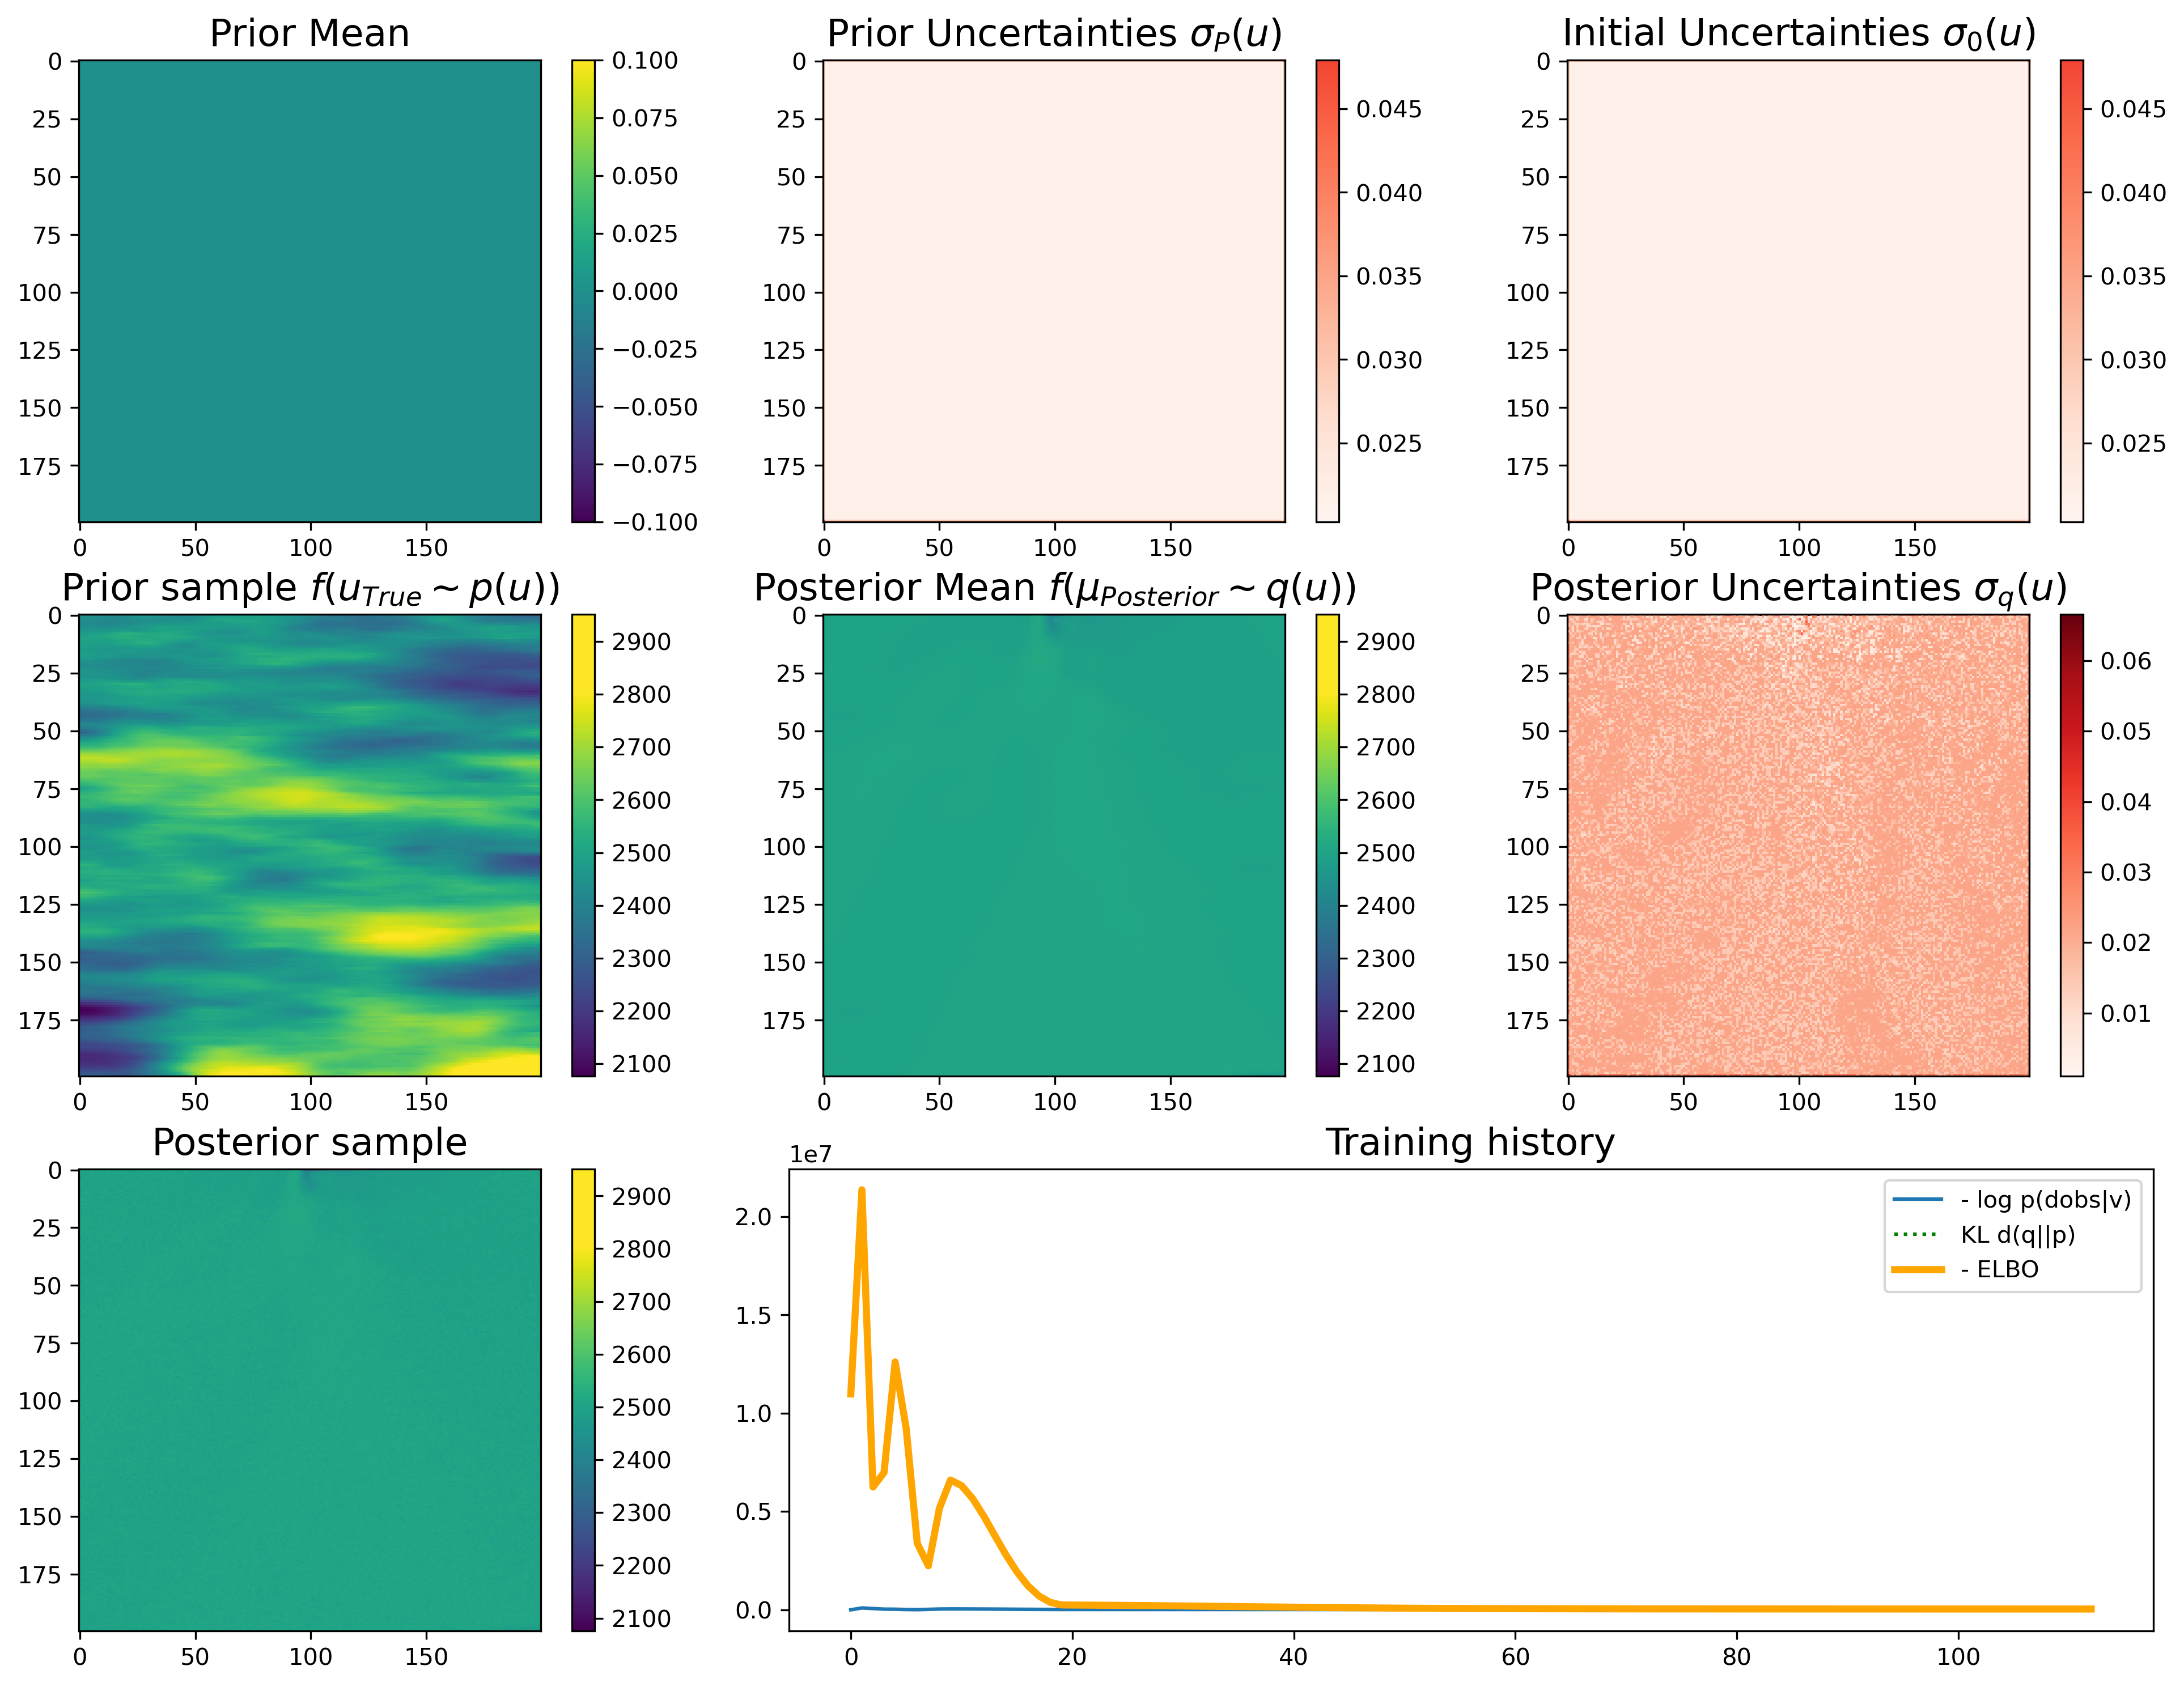

In [29]:
q_posterior = tfp.distributions.MultivariateNormalDiag(loc=q_mean, scale_diag=q_scale)
vmin, vmax = f(u_ref).min(), f(u_ref).max()

from matplotlib import cm
from matplotlib.colors import ListedColormap
viridisBig = cm.get_cmap('viridis', 512)
cmp = ListedColormap(viridisBig(np.linspace(0, 1.2, 256)))
Reds = cm.get_cmap('Reds', 512)
cmp_red = ListedColormap(Reds(np.linspace(0, 0.6, 256)))

plt.figure(figsize=(16,12),dpi=300)
plt.subplot(3,3,1)
plt.imshow(tf.reshape(p_dist.mean(),[nz,nx]))
plt.colorbar()
plt.title("Prior Mean", fontsize=16)

plt.subplot(3,3,2)
plt.imshow(tf.reshape(p_dist.stddev(),[nz,nx]),cmap=cmp_red)
plt.colorbar()
plt.title("Prior Uncertainties $\sigma_{P}(u)$", fontsize=16)

plt.subplot(3,3,3)
plt.imshow(tf.reshape(q_scale_init,[nz,nx]),cmap=cmp_red)
plt.colorbar()
plt.title("Initial Uncertainties $\sigma_{0}(u)$", fontsize=16)

plt.subplot(3,3,4)
plt.imshow(f(u_ref).reshape((nz,nx)),vmin=vmin, vmax=vmax, cmap=cmp)
plt.colorbar()
plt.title("Prior sample $f(u_{True} \sim p(u))$", fontsize=16)

plt.subplot(3,3,5)
plt.imshow(f(q_posterior.mean().numpy()).reshape((nz,nx)), vmin=vmin, vmax=vmax, cmap=cmp)
plt.colorbar()
plt.title("Posterior Mean $f(\mu_{Posterior} \sim q(u))$", fontsize=16)

plt.subplot(3,3,6)
plt.imshow(tf.reshape(q_posterior.stddev(),[nz,nx]),cmap='Reds')
plt.colorbar()
plt.title("Posterior Uncertainties $\sigma_{q}(u)$", fontsize=16)

plt.subplot(3,3,7)
plt.imshow(f(q_posterior.sample().numpy()).reshape((nz,nx)), vmin=vmin, vmax=vmax, cmap=cmp)
plt.colorbar()
plt.title("Posterior sample", fontsize=16)

plt.subplot(3,3,(8,9))
plt.plot(neg_loglik_history, label='- log p(dobs|v)')
plt.plot(kl_history, ls=":", label='KL d(q||p)', color='green')
plt.plot(neg_elbo_history, lw=3, label='- ELBO', color='orange')
plt.title("Training history", fontsize=16)
plt.legend()
plt.show()